# Latency analysis

In [ ]:
recording_files = {
    "2020-07-22T14-05-43": {
        "setup": 1,
        "volume_scale": 1
    },
    "2020-07-22T14-44-02": {
        "setup": 1,
        "volume_scale": 2
    },
    "2020-07-22T15-26-33": {
        "setup": 1,
        "volume_scale": 4
    },
    "2020-07-22T16-10-46": {
        "setup": 1,
        "volume_scale": 8
    },
    "2020-07-22T17-28-28": {
        "setup": 1,
        "volume_scale": 16
    },
    "2020-07-23T07-18-07": {
        "setup": 1,
        "volume_scale": 1
    },
    "2020-07-23T08-10-17": {
        "setup": 1,
        "volume_scale": 2
    },
    "2020-07-23T08-50-59": {
        "setup": 1,
        "volume_scale": 4
    },
    "2020-07-23T09-35-16": {
        "setup": 1,
        "volume_scale": 8
    },
    "2020-07-23T10-13-55": {
        "setup": 1,
        "volume_scale": 16
    },
    "2020-07-23T12-19-24": {
        "setup": 1,
        "volume_scale": 0
    },
    "2020-07-23T14-19-14": {
        "setup": 2,
        "volume_scale": 1
    },
    "2020-07-23T15-00-50": {
        "setup": 2,
        "volume_scale": 2
    },
    "2020-07-23T15-33-30": {
        "setup": 2,
        "volume_scale": 4
    },
    "2020-07-23T16-06-56": {
        "setup": 2,
        "volume_scale": 8
    },
    "2020-07-23T16-41-55": {
        "setup": 2,
        "volume_scale": 16
    },
#     "2020-07-24T08-41-38": {
#         "setup": 3,
#         "volume_scale": 32
#     },
#     "2020-07-24T09-18-07": {
#         "setup": 3,
#         "volume_scale": 32
#     },
    "2020-07-24T09-44-25": {
        "setup": 3,
        "volume_scale": 16
    },
    "2020-07-24T10-18-10": {
        "setup": 3,
        "volume_scale": 8
    },
     "2020-07-27T10-25-49": {
        "setup": 4,
        "volume_scale": 1
    },
    "2020-07-27T11-02-10": {
        "setup": 4,
        "volume_scale": 2
    },
    "2020-07-27T11-34-51": {
        "setup": 4,
        "volume_scale": 4
    },
    "2020-07-27T12-07-03": {
        "setup": 4,
        "volume_scale": 8
    },
    "2020-07-27T12-42-29": {
        "setup": 4,
        "volume_scale": 16
    },
#     "2020-07-27T14-51-04": {
#         "setup": 4,
#         "volume_scale": 32
#     },
#     "2020-07-27T15-27-28": {
#         "setup": 4,
#         "volume_scale": 1
#     },
#     "2020-07-27T15-59-57": {
#         "setup": 4,
#         "volume_scale": 2
#     },
    "2020-07-27T17-38-04": {
         "setup": 5,
        "volume_scale": 1
    },
    "2020-07-27T18-12-59":  {
         "setup": 5,
        "volume_scale": 2
    },
    "2020-07-27T18-52-11":  {
         "setup": 5,
        "volume_scale": 4
    },
    "2020-07-27T19-32-32":  {
         "setup": 5,
        "volume_scale": 8
    },
    "2020-07-27T20-39-54":  {
         "setup": 5,
        "volume_scale": 16
    },
}

axislim_margin = 0.03
time_lim = 30 * 60

In [2]:
import os

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from ptinsight.common.latency import calculate_latencies
from ptinsight.common.plotting import plot_init, plot_format, plot_subplot, plot_save, add_relative_time

In [3]:
def select_job(data, job):
    """Get all rows for a specific job"""
    return data[data["job"] == job]

## Preprocessing

In [4]:
plot_init()

datas = {}
jobs = set()
setups = {}
volume_scales = {}

# did = data id since id is a builtin
for did in sorted(list(recording_files.keys())):
    data = pd.read_csv(f"recordings/{did}.csv")
    add_relative_time(data, "ingress_ingestion_timestamp")
    calculate_latencies(data)
    
    data = data[data["t"] <= time_lim]
    
    jobs.update(data["job"])
    
    volume_scale = recording_files[did]["volume_scale"]
    setup = int(recording_files[did]["setup"])
    if not volume_scale in volume_scales:
        volume_scales[volume_scale] = {}
    if not setup in volume_scales[volume_scale]:
        volume_scales[volume_scale][setup] = []
    volume_scales[volume_scale][setup].append(did)
    
    if not setup in setups:
        setups[setup] = []
    setups[setup].append(did)
    
    datas[did] = data
    
n_data = len(recording_files)

jobs = sorted(jobs)
n_jobs = len(jobs)

setups = dict(sorted(setups.items()))
del setups[1]
del setups[2]
del setups[3]
del setups[4]
n_setups = len(setups)

volume_scales = dict(sorted(volume_scales.items()))
volume_scales_no_live = { s: volume_scales[s] for s in volume_scales.keys() if s != 0 }

latency_cols = [col for col in datas[did] if col.startswith("latency")]
latency_cols_no_e2e = [col for col in latency_cols if not "end_to_end" in col]

max_latency = max([data[latency_cols_no_e2e].max().max() for data in datas.values()])
max_t = max([data["t"].max() for data in datas.values()])

## Descriptive statistics of latencies per job

In [5]:
def show_descriptive_statistics():
    for did, data in datas.items():
        display(Markdown(f"### ID: {did}"))
        for job in jobs:
            display(Markdown(f"#### Job: {job}"))
            display(select_job(data, job)[latency_cols].describe())

# show_descriptive_statistics()

In [6]:
def show_cep_streaming_vs_table():
    # To check if both streaming and table-based CEP give same results
    for did, data in datas.items():
        print(f"ID: {did}")
        for job in jobs:
            if "emergency-stop" in job:
                print(f"   {job}: n={select_job(data, job)['t'].count()}")

# show_cep_streaming_vs_table()

In [7]:
def show_recording_length():
    for did, data in datas.items():
        print(f"ID: {did}   max_t: {data['t'].max()} s")
        
show_recording_length()

ID: 2020-07-22T14-05-43   max_t: 1799.748 s
ID: 2020-07-22T14-44-02   max_t: 1799.882 s
ID: 2020-07-22T15-26-33   max_t: 1799.604 s
ID: 2020-07-22T16-10-46   max_t: 1799.606 s
ID: 2020-07-22T17-28-28   max_t: 1799.054 s
ID: 2020-07-23T07-18-07   max_t: 1799.86 s
ID: 2020-07-23T08-10-17   max_t: 1799.246 s
ID: 2020-07-23T08-50-59   max_t: 1799.07 s
ID: 2020-07-23T09-35-16   max_t: 1799.202 s
ID: 2020-07-23T10-13-55   max_t: 1799.645 s
ID: 2020-07-23T12-19-24   max_t: 1799.66 s
ID: 2020-07-23T14-19-14   max_t: 1799.959 s
ID: 2020-07-23T15-00-50   max_t: 1799.798 s
ID: 2020-07-23T15-33-30   max_t: 1799.196 s
ID: 2020-07-23T16-06-56   max_t: 1799.034 s
ID: 2020-07-23T16-41-55   max_t: 1799.179 s
ID: 2020-07-24T09-44-25   max_t: 1799.945 s
ID: 2020-07-24T10-18-10   max_t: 1799.938 s
ID: 2020-07-27T10-25-49   max_t: 1799.449 s
ID: 2020-07-27T11-02-10   max_t: 1799.423 s
ID: 2020-07-27T11-34-51   max_t: 1799.118 s
ID: 2020-07-27T12-07-03   max_t: 1799.192 s
ID: 2020-07-27T12-42-29   max_t: 17

## Latency distribution by job

In [8]:
def plot_latency_distribution_by_job():
    latency_lim = min(20000, max_latency)
    for job in jobs:
        fig, axs = plot_subplot(n_data)
        
        fig.suptitle(f"Latencies for job \"{job}\"")
        
        for i, (did, data) in enumerate(datas.items()):
            ax = axs[i]

            sb.boxenplot(data=select_job(data, job)[latency_cols], orient="h", ax=ax)
            ax.set_xlim([-axislim_margin * latency_lim, latency_lim * (1 + axislim_margin)])
            ax.set_title(f"ID: {did}")
            ax.set_xlabel("Time [s]")
            if i+1 == len(jobs):
                ax.set_xlabel("Latency [ms]")
        
        plot_format(fig)
        plot_save(f"latency_distribution_by_job_{job}")
    
# plot_latency_distribution_by_job()

## End-to-End Latency distribution by Volume Scale

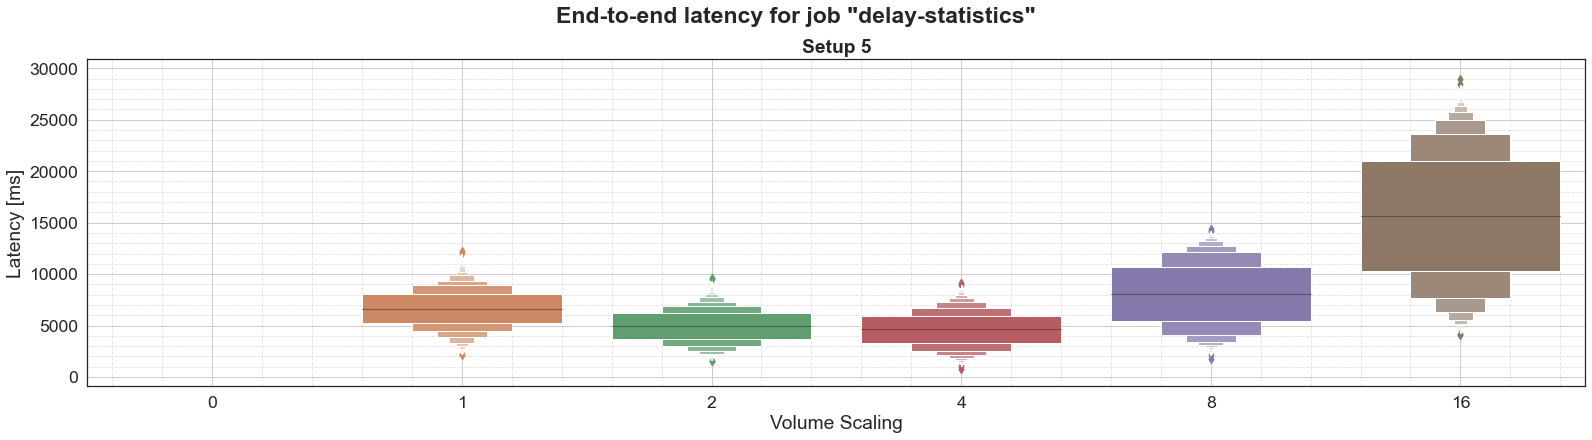

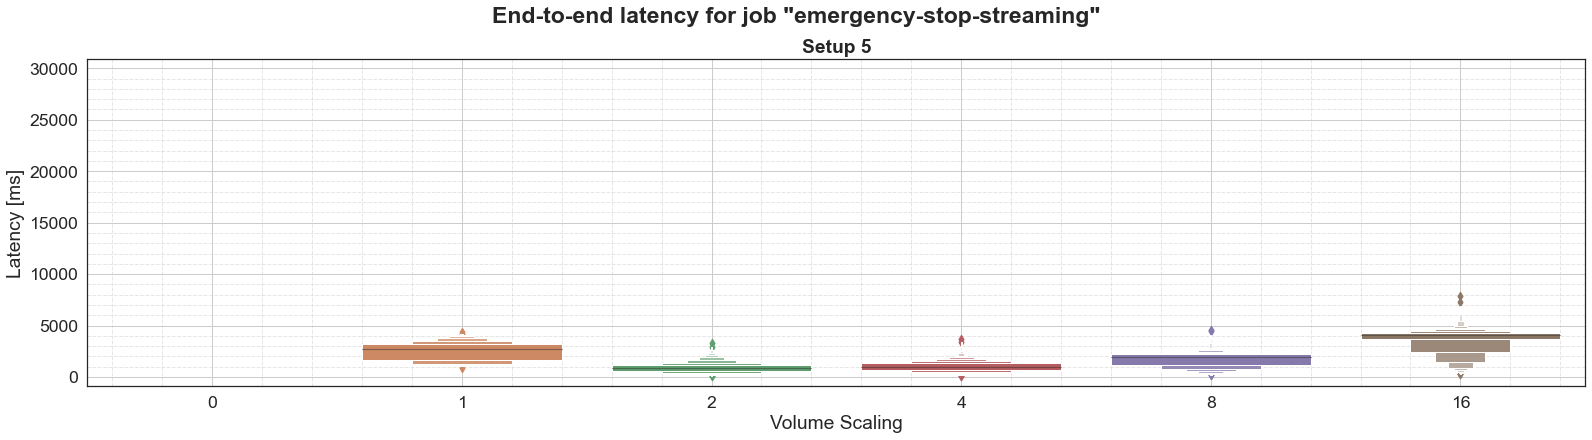

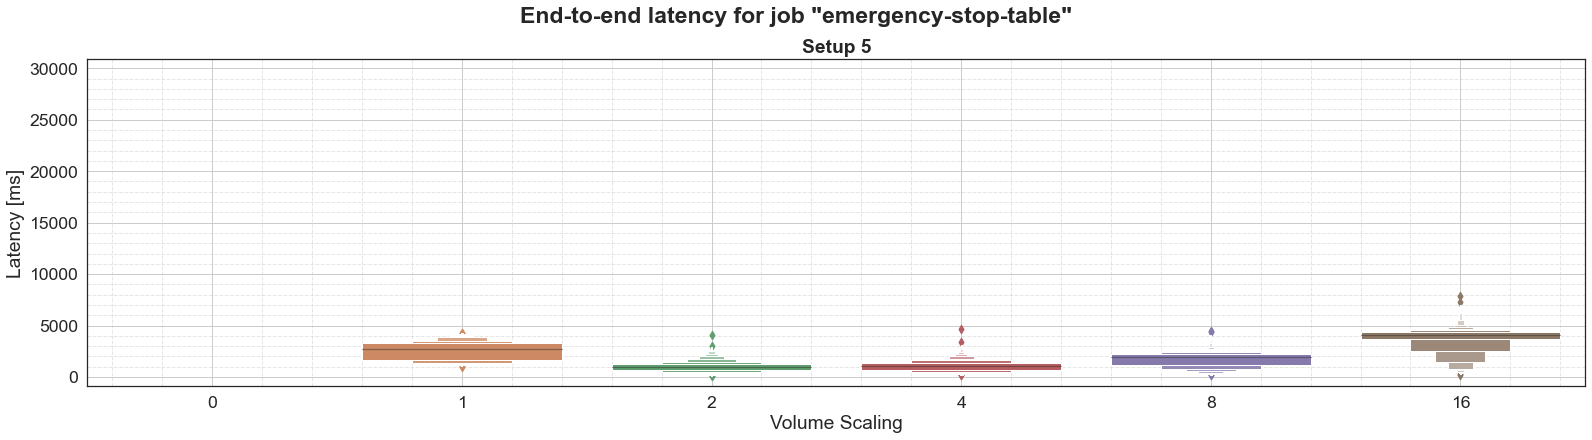

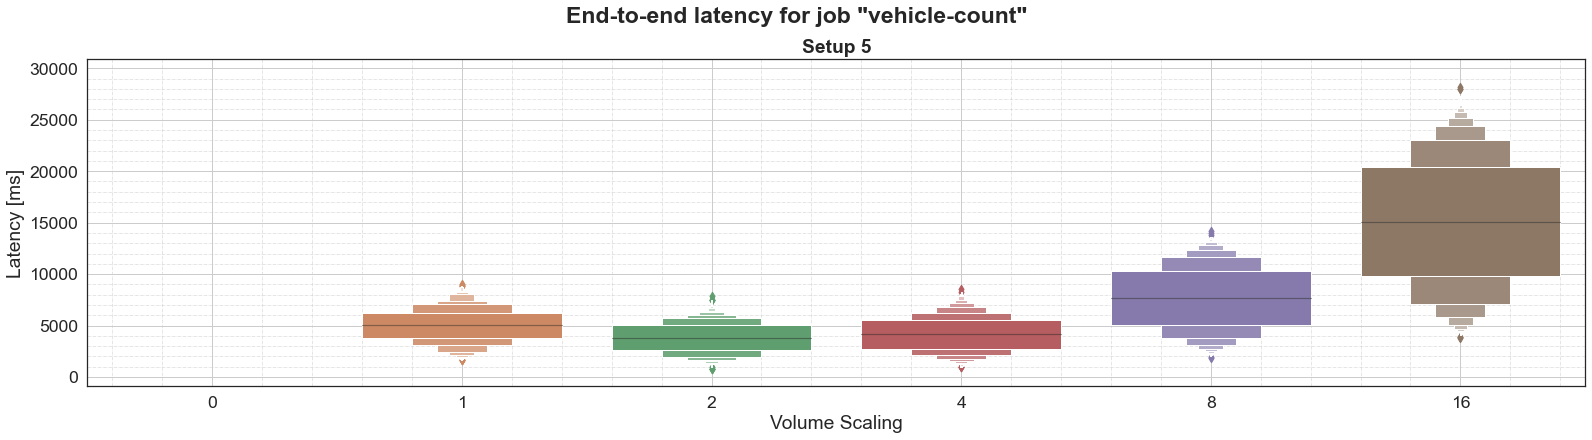

In [9]:
def plot_latency_distribution_by_scale():
    latency_lim = min(30000, max_latency)
    for job in jobs:
        fig, axs = plot_subplot(n_setups)
        
        fig.suptitle(f"End-to-end latency for job \"{job}\"")
        
        for i, setup in enumerate(setups):
            ax = axs[i]
            
            ax.set_title(f"Setup {setup}")

            data = pd.DataFrame()
            for volume_scale, setups_for_volume in volume_scales.items():
                if setup in setups_for_volume:
                    data[volume_scale] = pd.concat([select_job(datas[did], job)["latency_end_to_end"] for did in setups_for_volume[setup]], ignore_index=True)
                else:
                    data[volume_scale] = pd.Series([], dtype=object)

            sb.boxenplot(data=data, ax=ax)
            ax.set_ylim([-axislim_margin * latency_lim, latency_lim * (1 + axislim_margin)])
            ax.set_xlabel("Volume Scaling")
            ax.set_ylabel("Latency [ms]")
        
        plot_format(fig)
        plot_save(f"latency_distribution_by_scale_{job}")
    
plot_latency_distribution_by_scale()

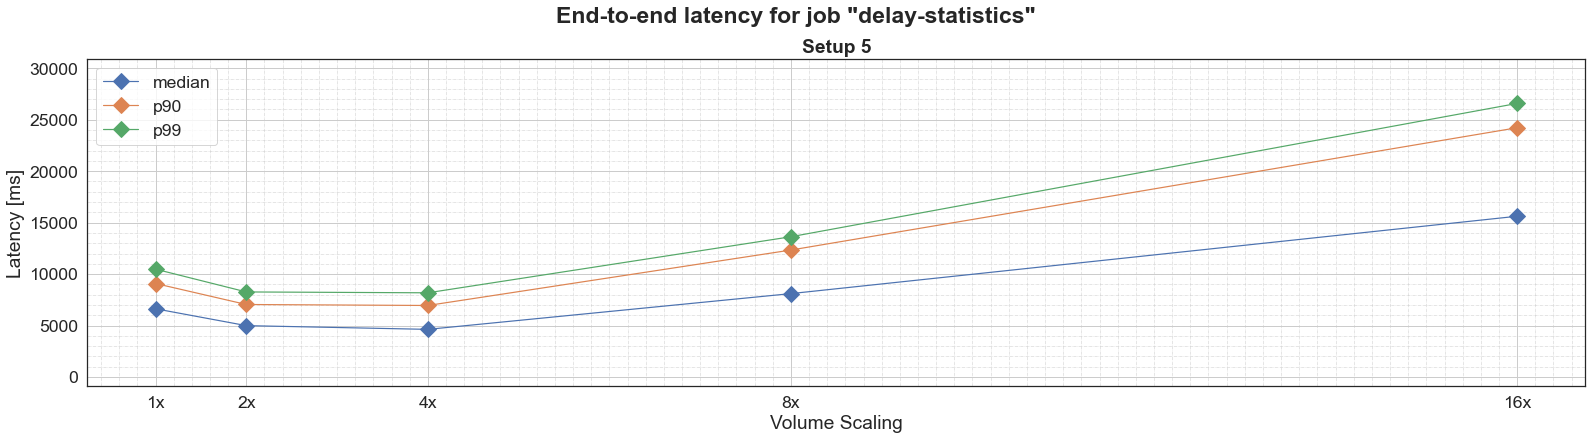

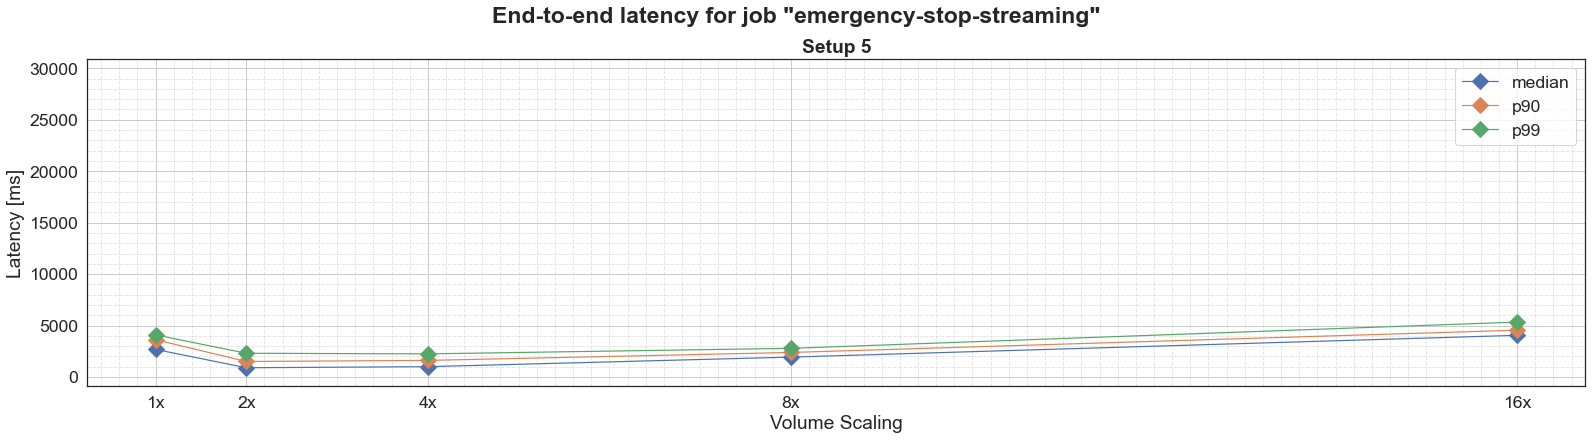

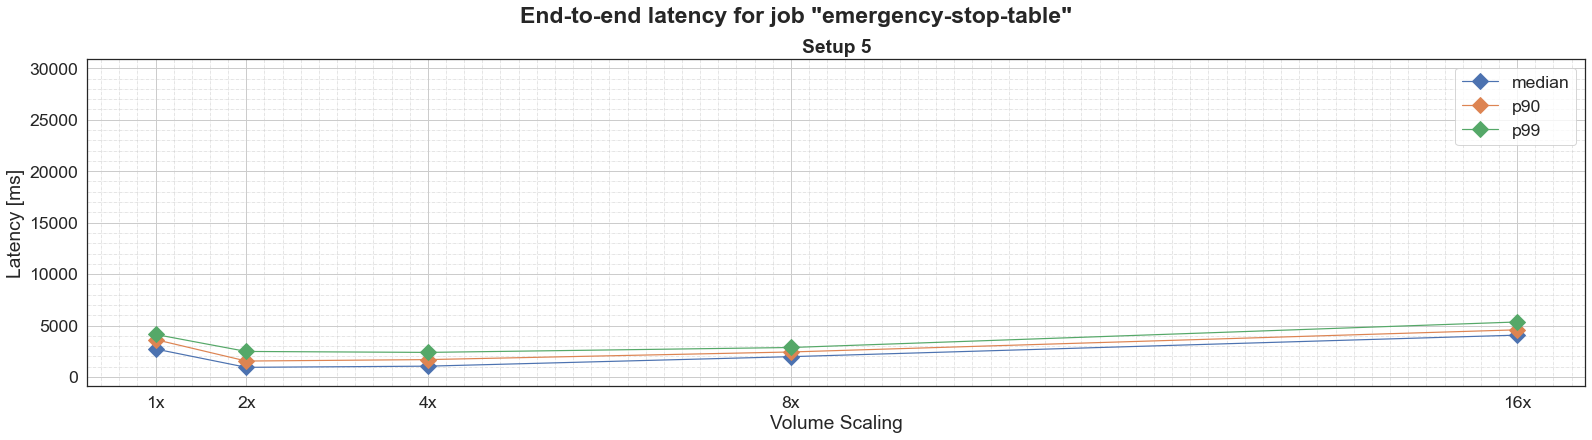

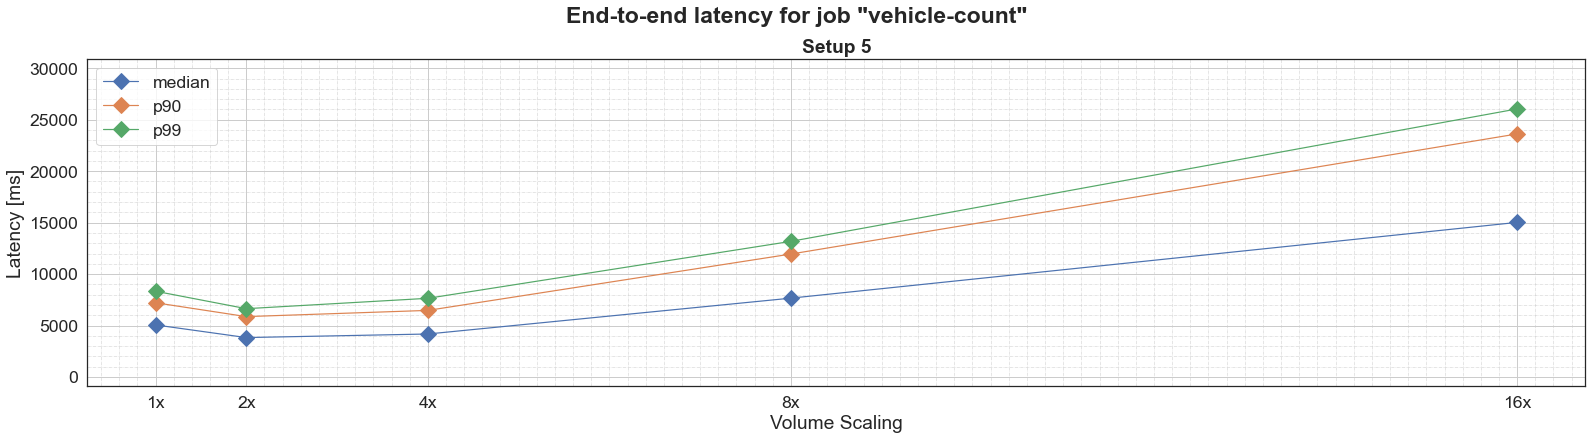

In [10]:
def plot_latency_percentiles_by_scale():
    latency_lim = min(30000, max_latency)
    for job in jobs:
        fig, axs = plot_subplot(n_setups)
        
        fig.suptitle(f"End-to-end latency for job \"{job}\"")
        
        for i, setup in enumerate(setups):
            ax = axs[i]
        
            ax.set_title(f"Setup {setup}")
        
            for pct, label in zip([0.5, 0.9, 0.99], ["median", "p90", "p99"]):
                data = {}
                for volume_scale, setups_for_volume in volume_scales_no_live.items():
                    if setup in setups_for_volume:
                        v = pd.concat([select_job(datas[did], job)["latency_end_to_end"] for did in setups_for_volume[setup]], ignore_index=True).quantile(pct)
                        data[volume_scale] = v
                ax.plot(pd.DataFrame.from_dict(data, orient="index"), 'D-', markersize=12, label=label) 
            ax.legend()
            ax.set_ylim([-axislim_margin * latency_lim, latency_lim * (1 + axislim_margin)])
            ax.set_xlabel("Volume Scaling")
            ax.set_xticks(list(volume_scales_no_live.keys()))
            ax.set_xticklabels([f"{s}x" for s in volume_scales_no_live.keys()])
            ax.set_ylabel("Latency [ms]")
        
        plot_format(fig)
        plot_save(f"latency_percentiles_by_scale_{job}")
    
plot_latency_percentiles_by_scale()

## Latency over time per job

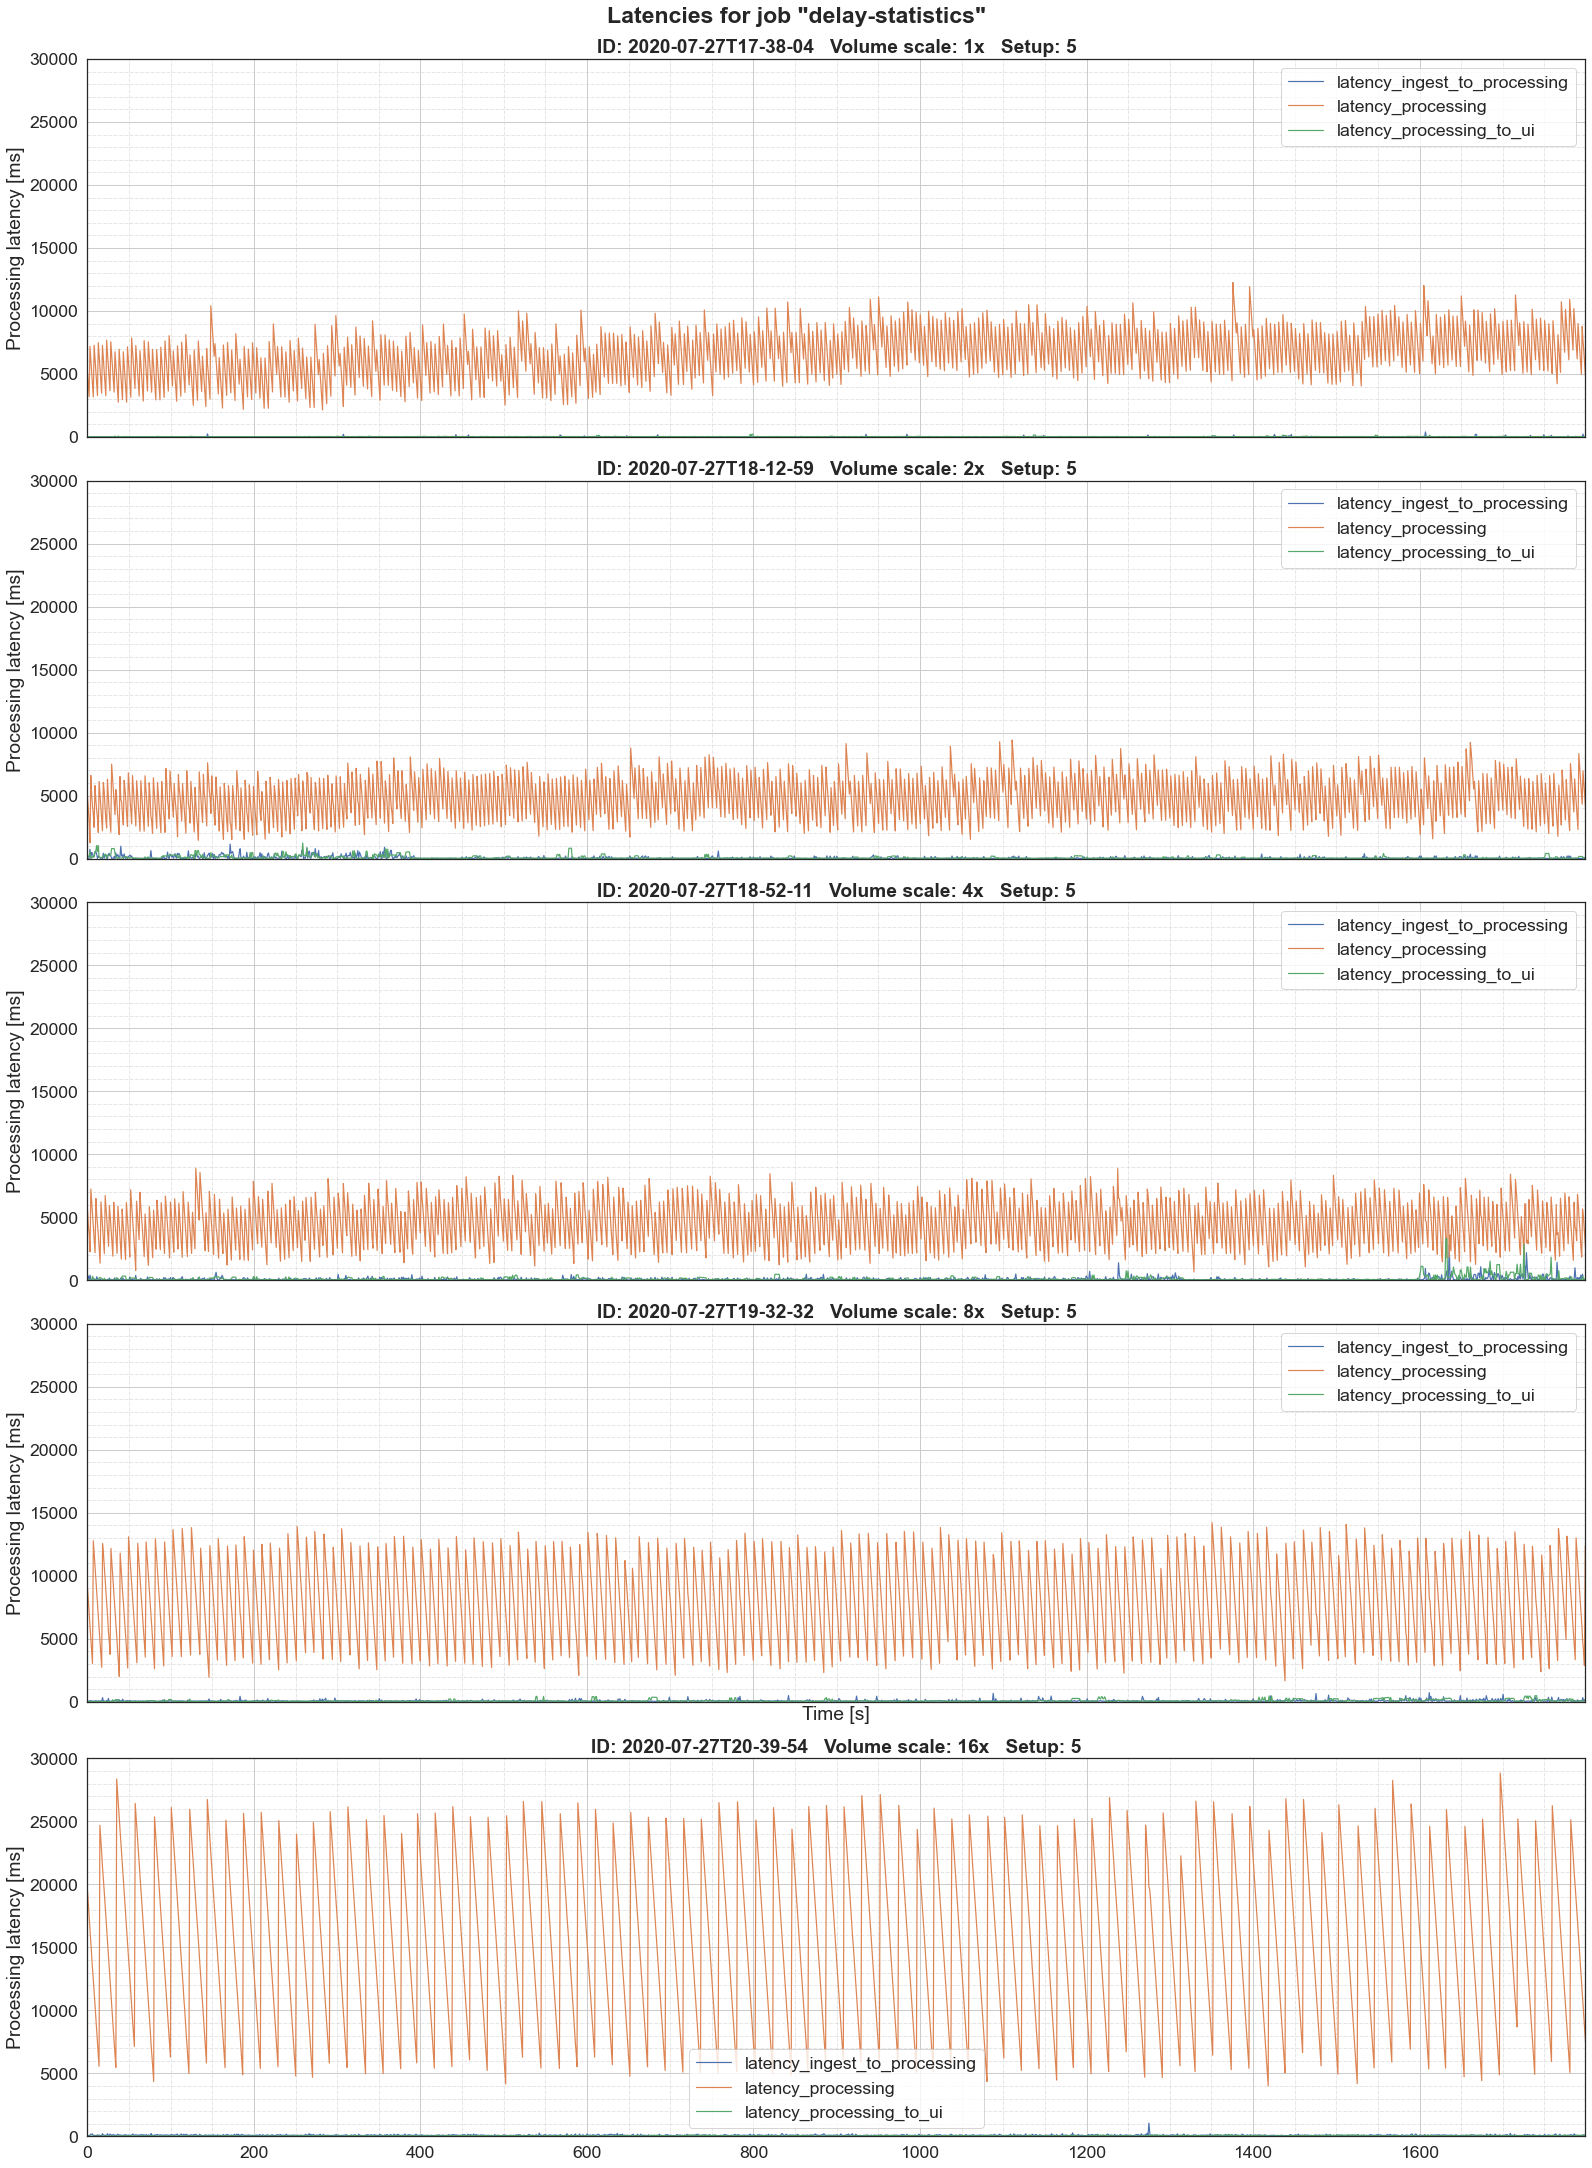

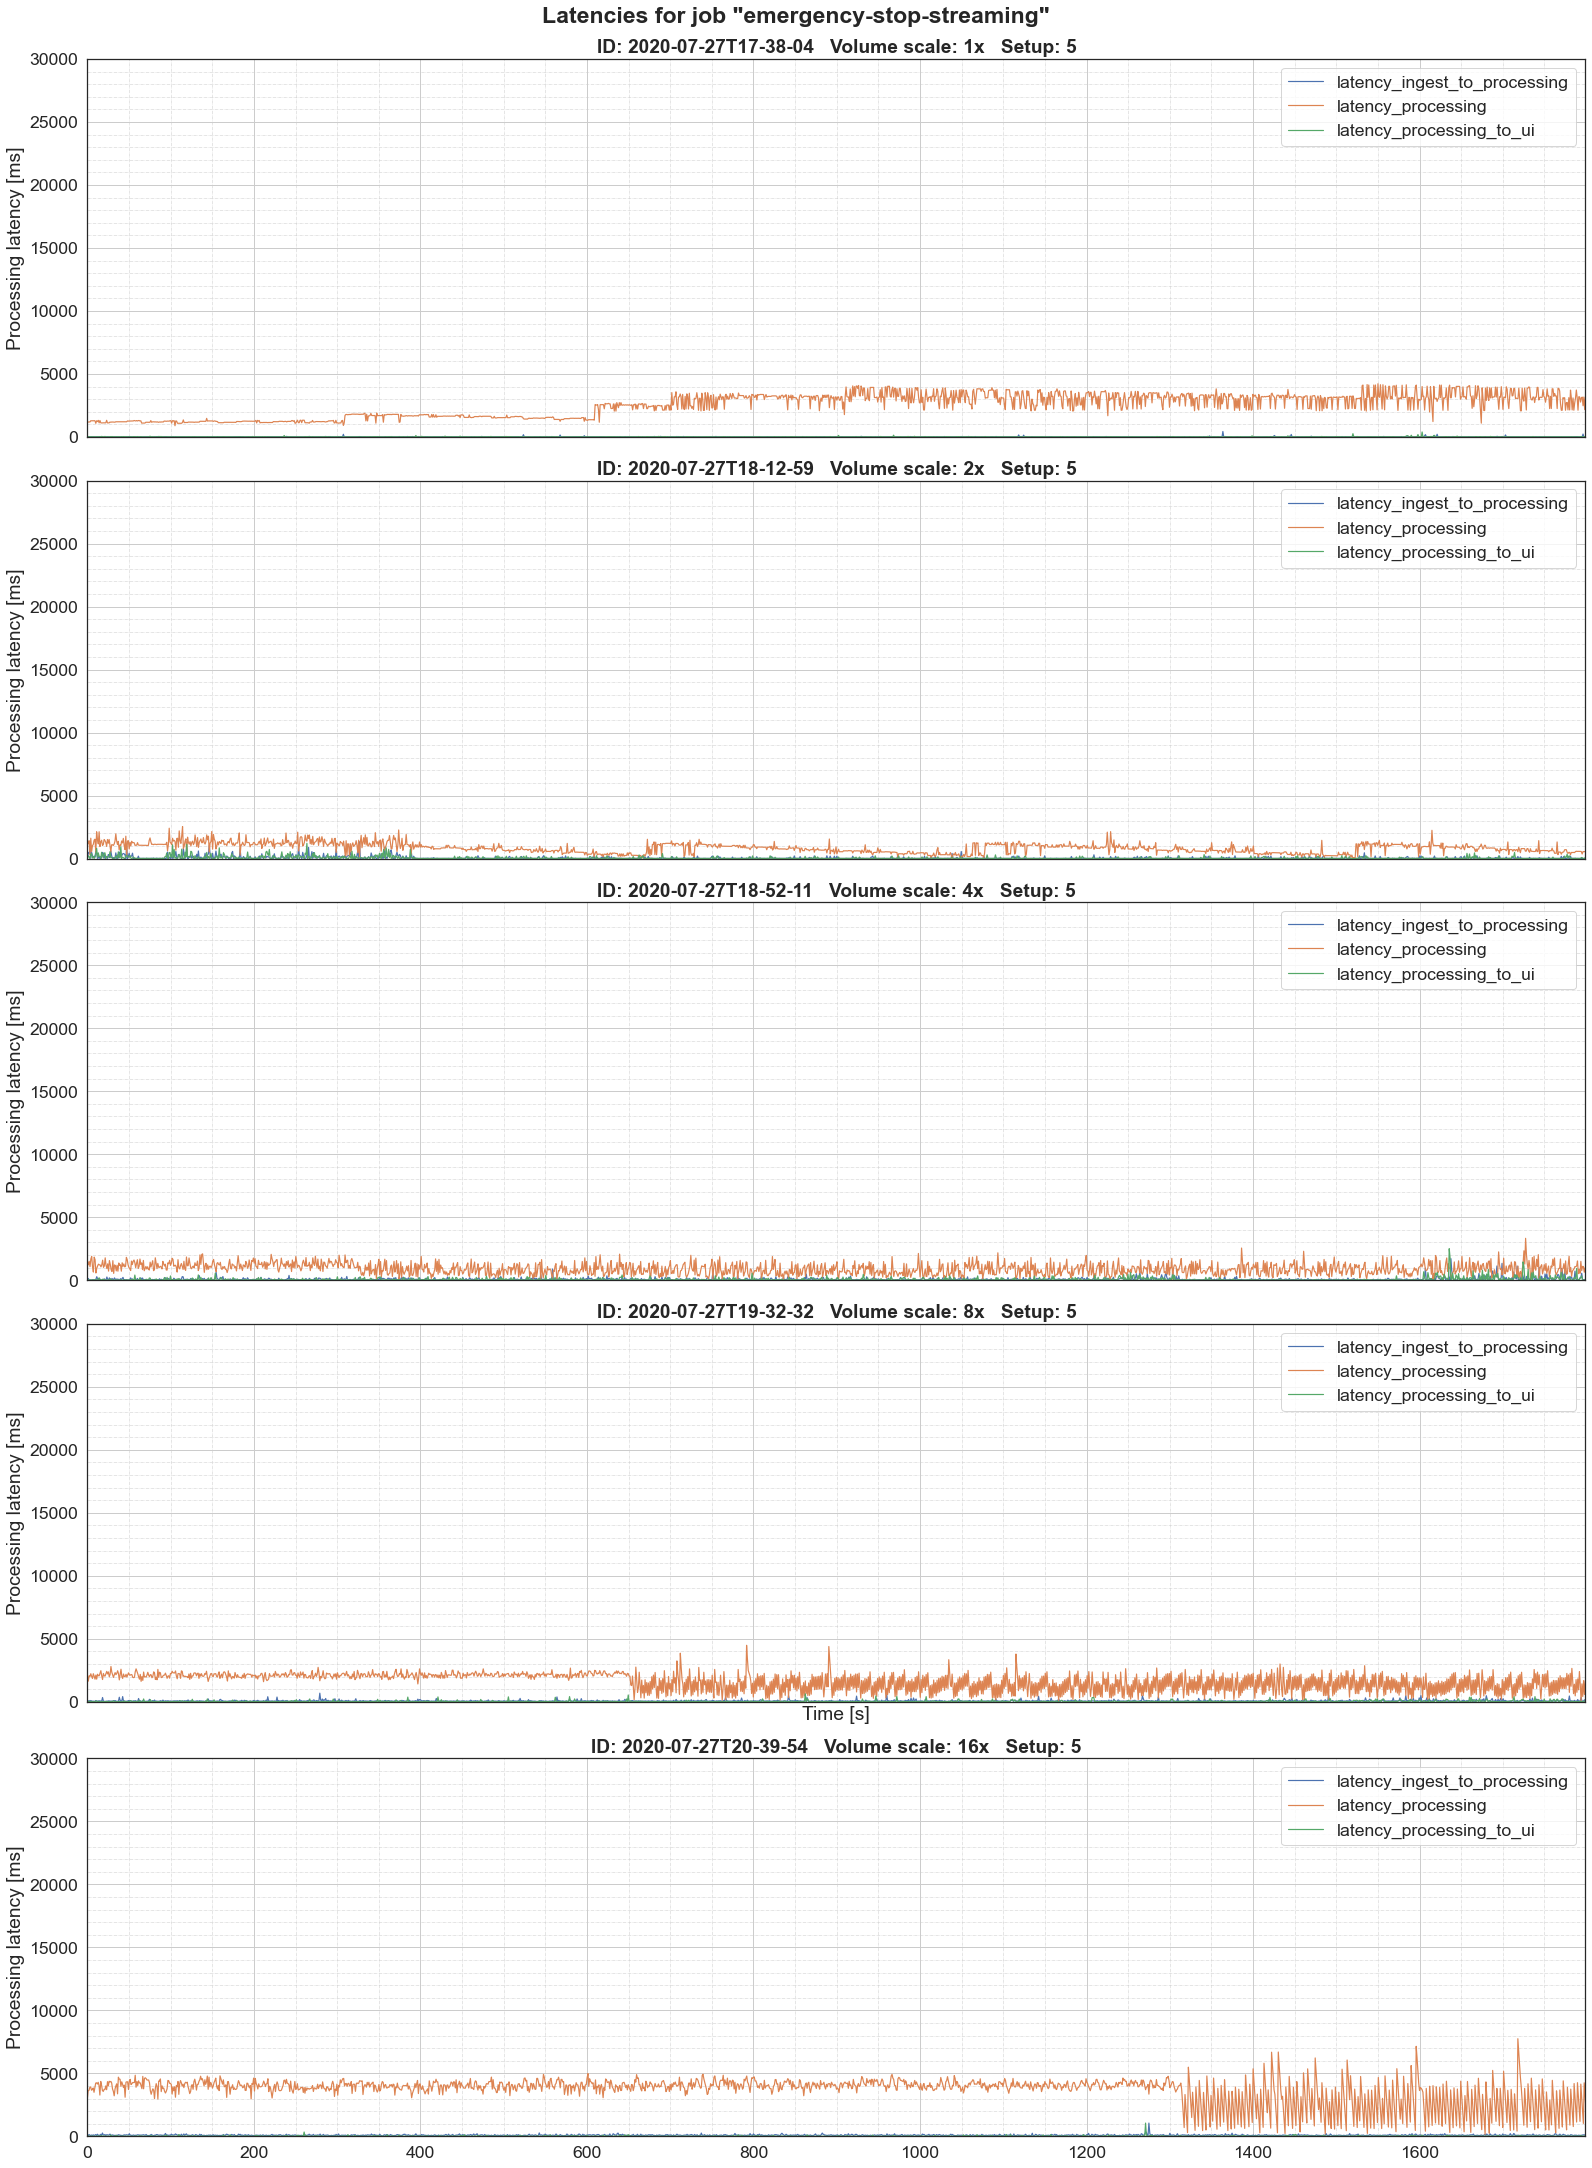

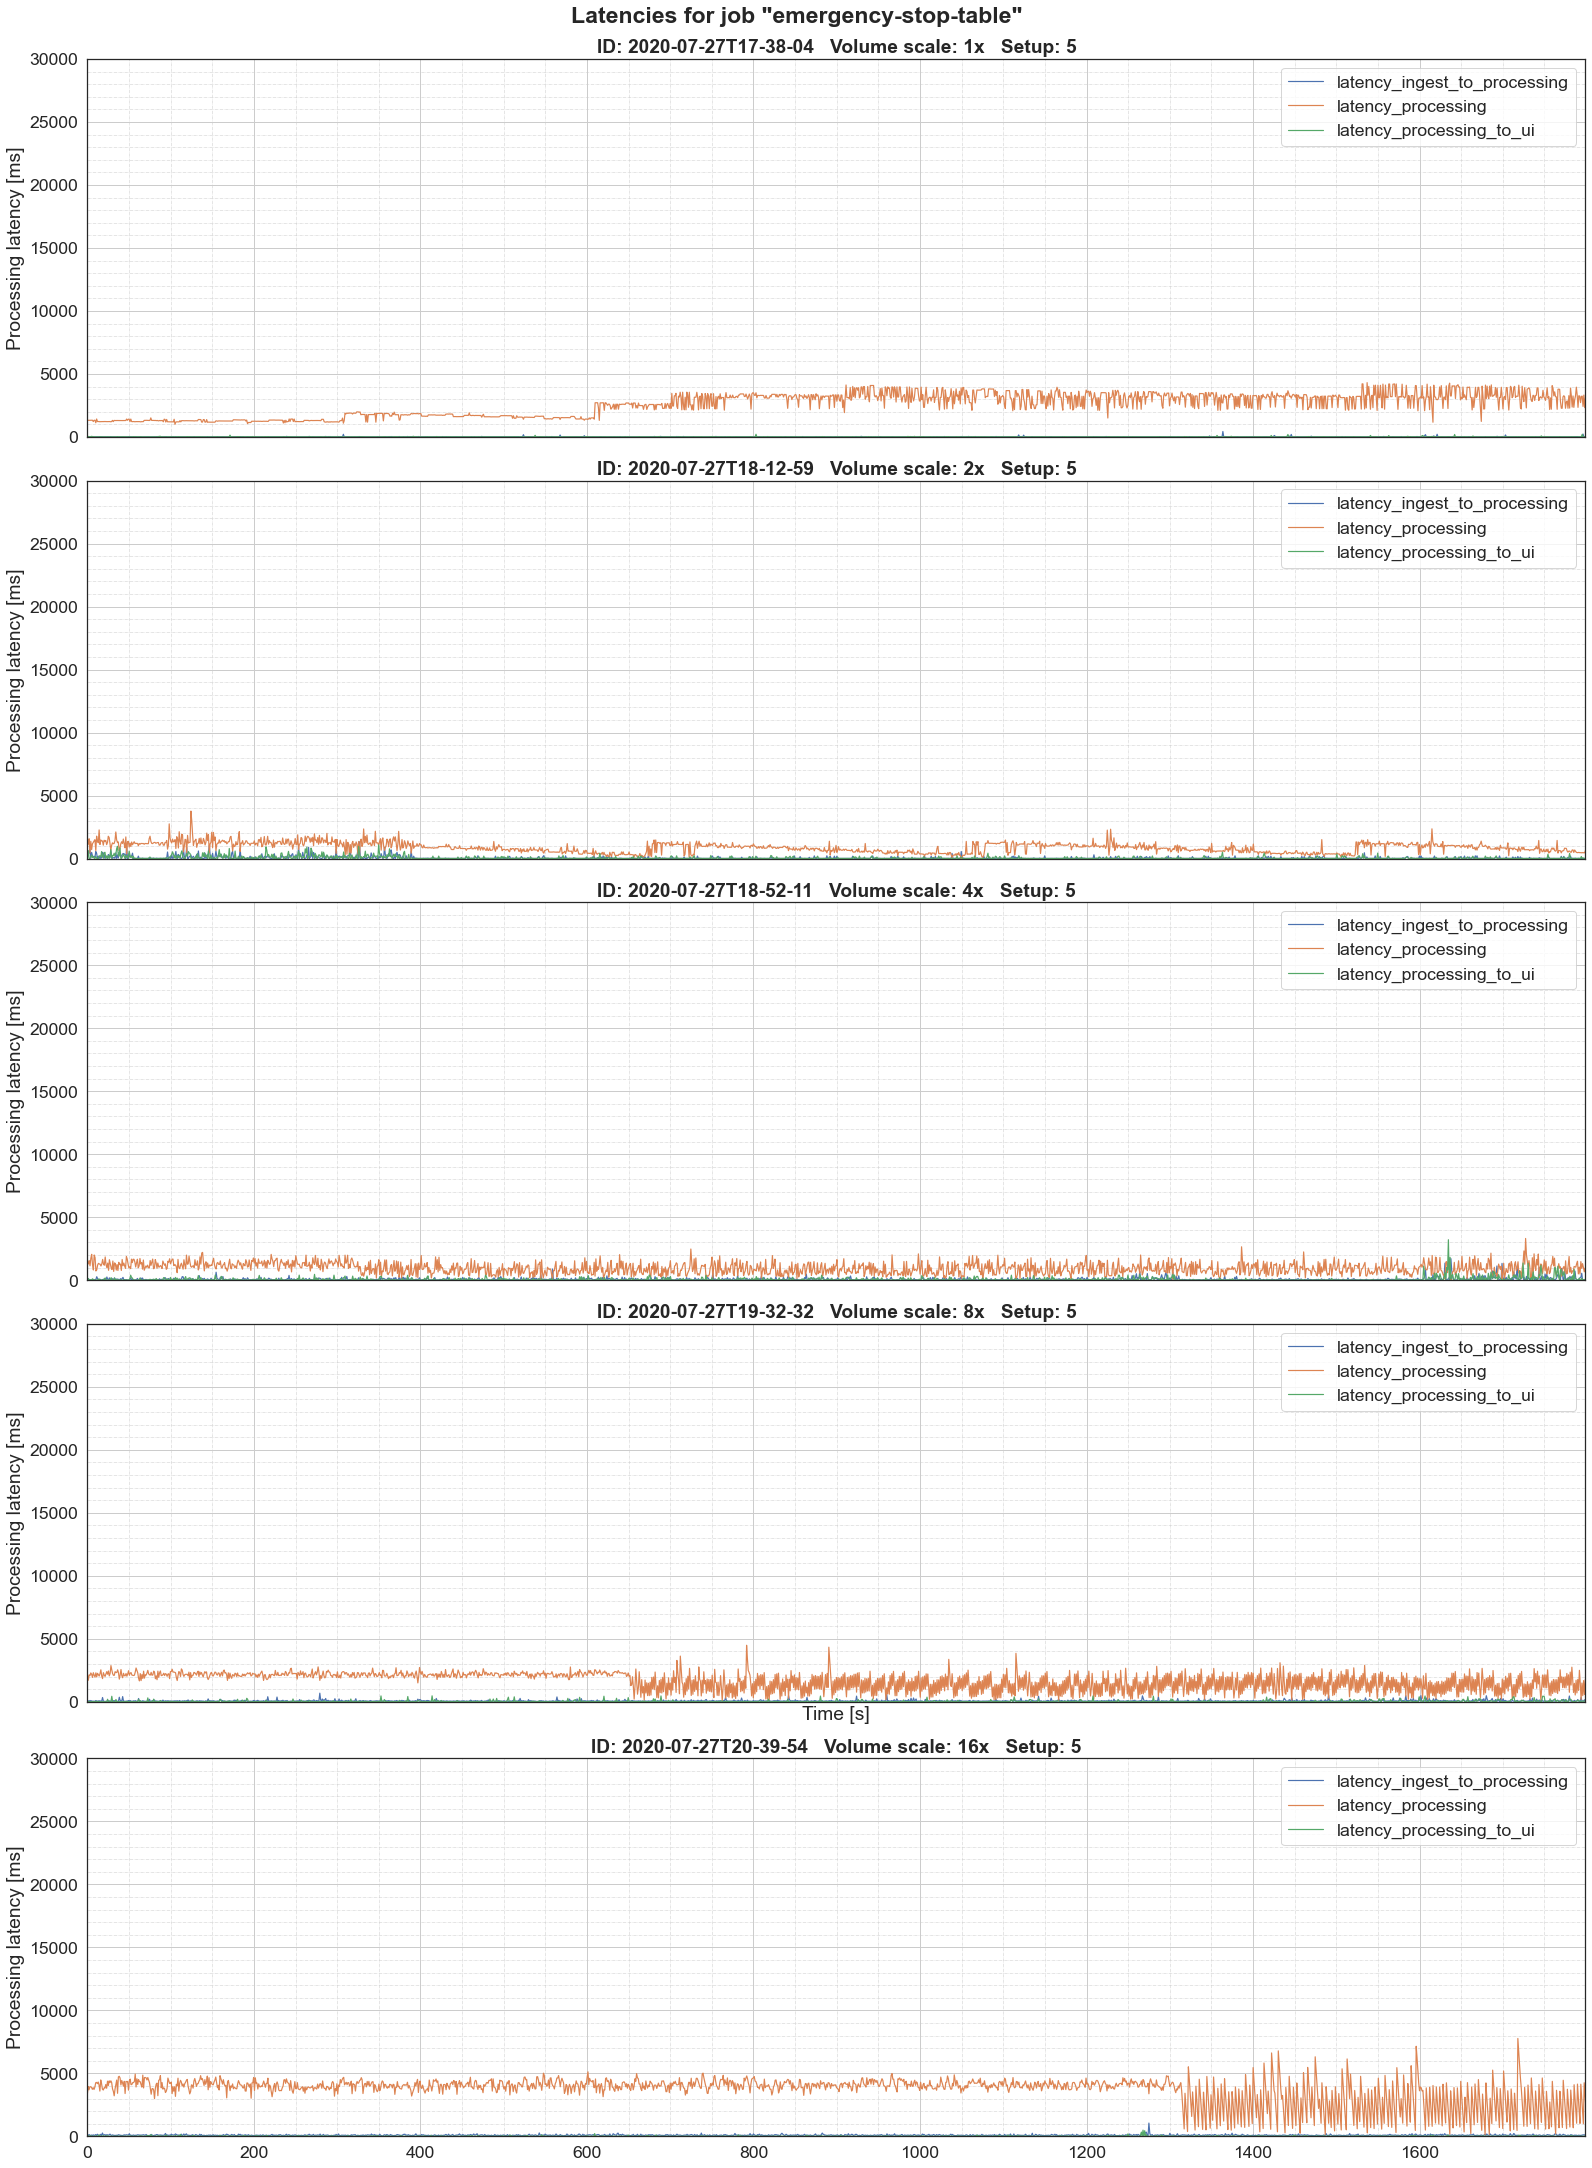

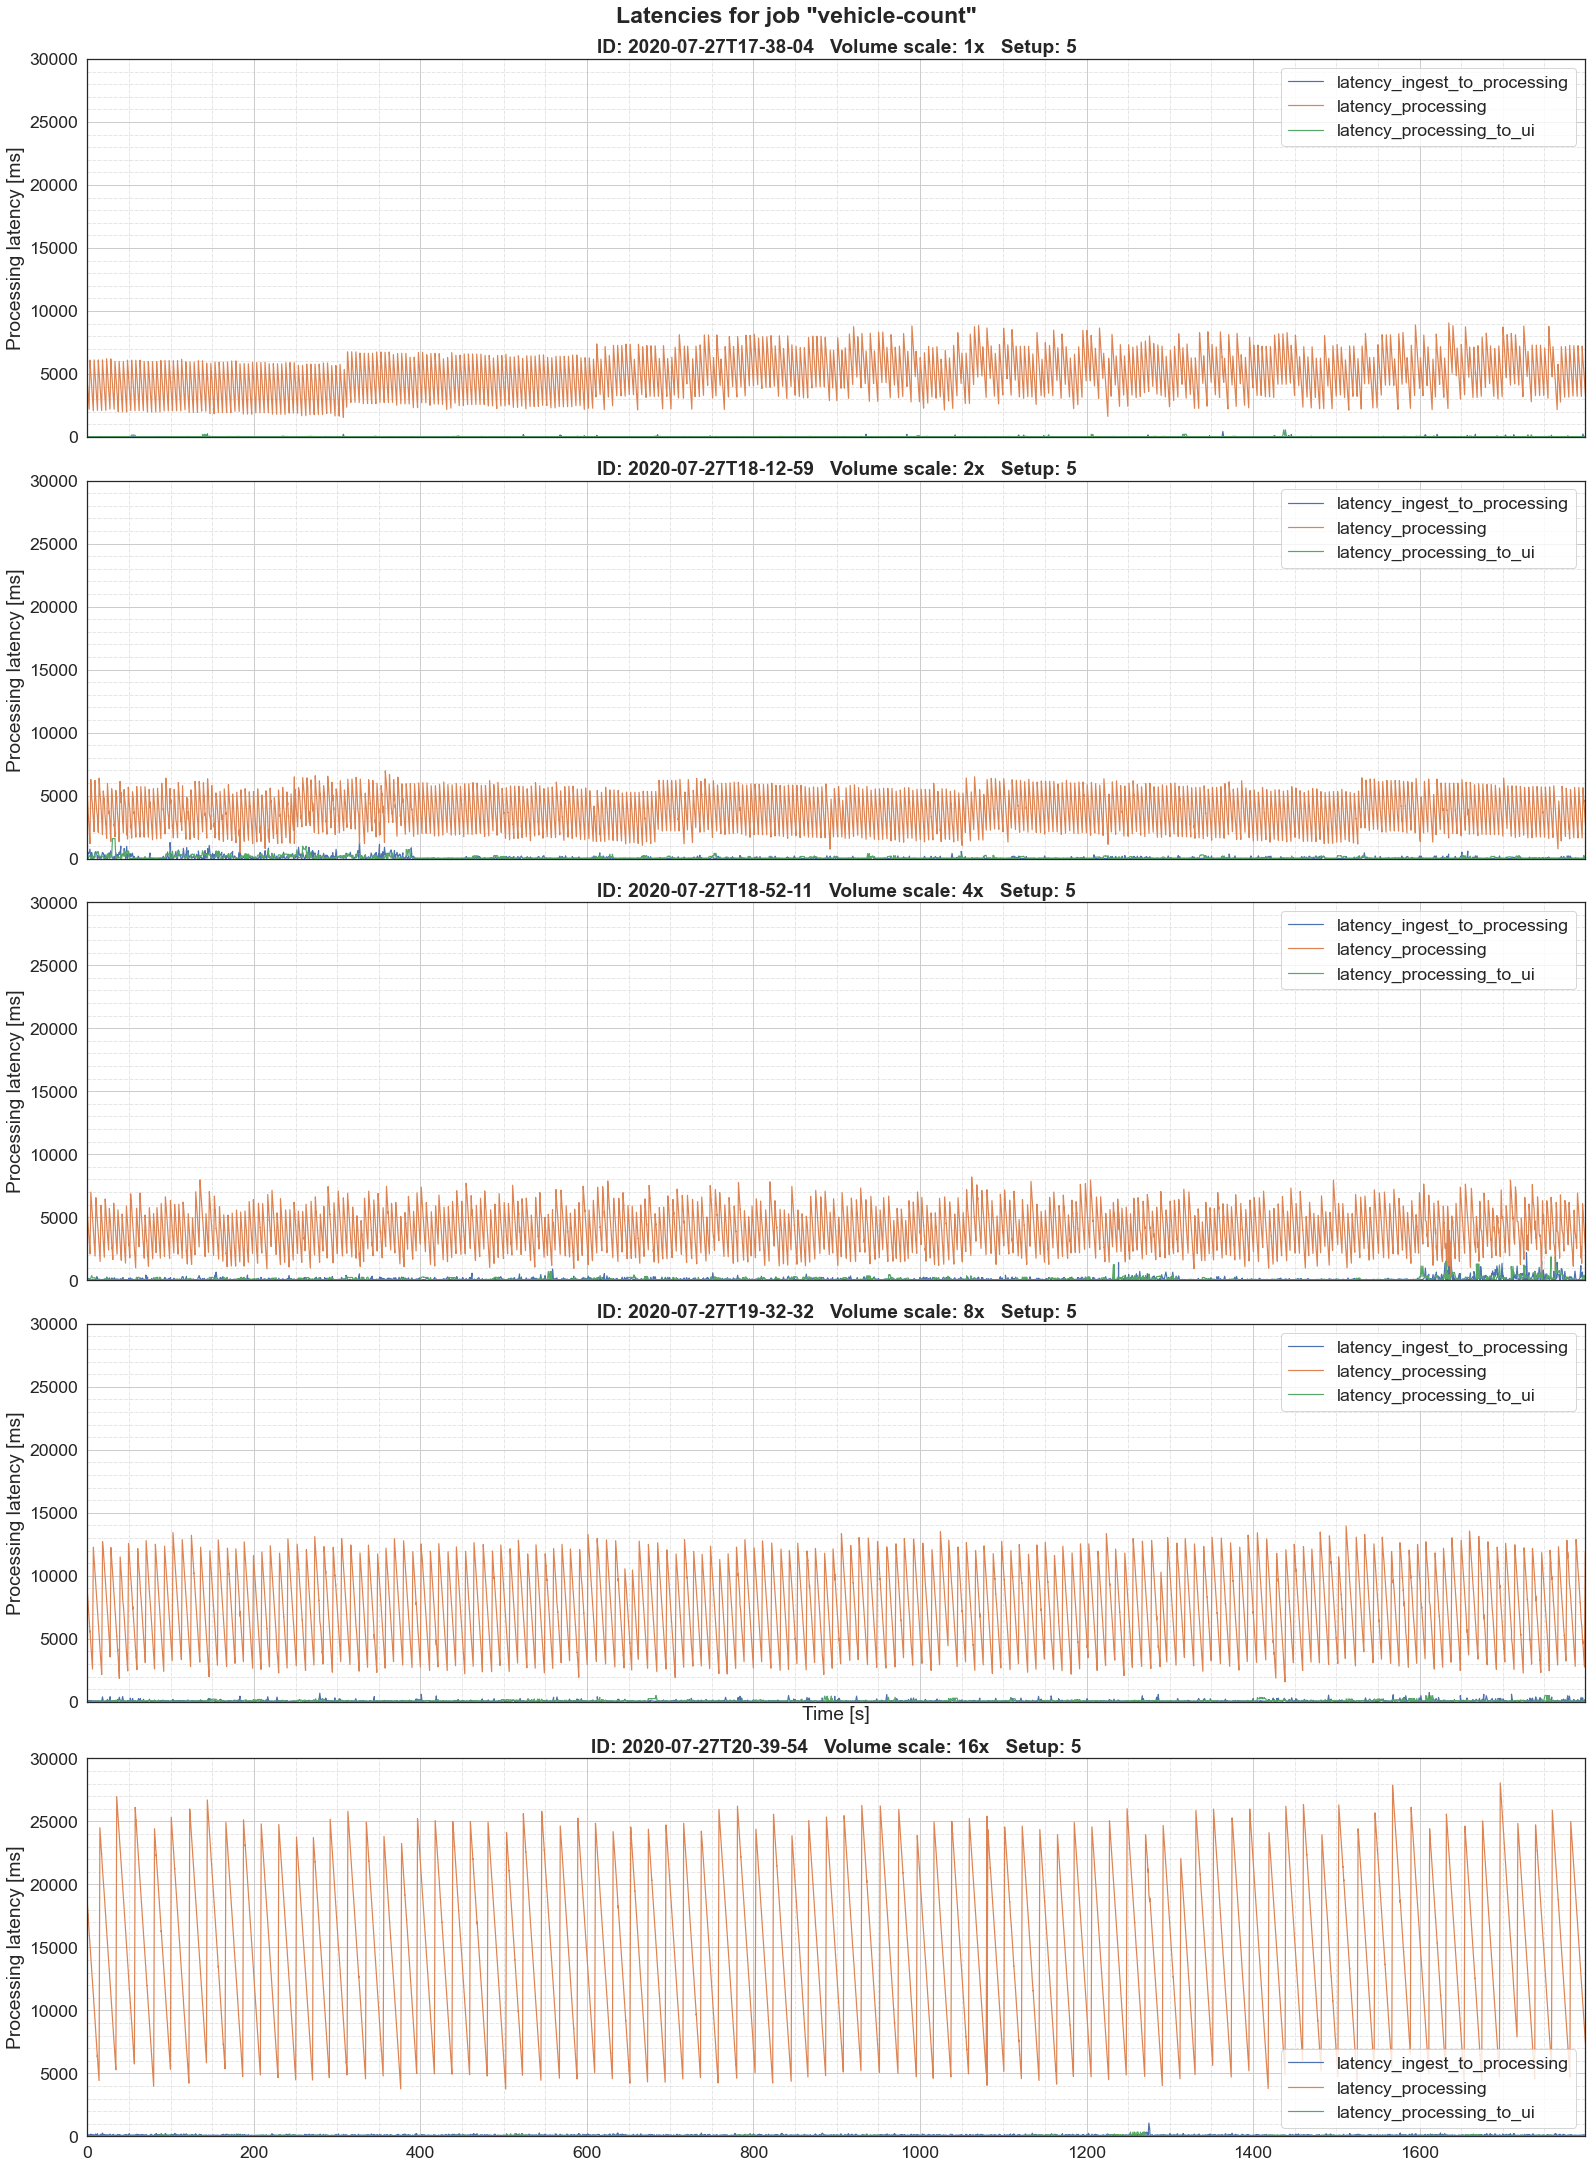

In [11]:
def plot_latency_over_time():
#     dids_to_plot = list(datas.keys())[-1:]
    dids_to_plot = setups[5]
    
    latency_lim = min(30000, max_latency)
    for t_lim in [int(max_t)]:
        for job in jobs:
            fig, axs = plot_subplot(len(dids_to_plot))

            fig.suptitle(f"Latencies for job \"{job}\"")
            
            for i, did in enumerate(dids_to_plot):
                job_data = select_job(datas[did], job)
                ax = axs[i]

                for col in latency_cols_no_e2e:
                    ax.plot(job_data["t"], job_data[col], label=col)
                        
                if t_lim == 60:
                    ax.set_xlim([30, 30+t_lim])
                else:
                    ax.set_xlim([0, t_lim])
                ax.set_ylim([0, latency_lim])
                ax.set_ylabel("Processing latency [ms]")
                ax.set_title(f"ID: {did}   Volume scale: {recording_files[did]['volume_scale']}x   Setup: {recording_files[did]['setup']}")
                ax.legend()
                if i+1 == len(jobs):
                    ax.set_xlabel("Time [s]")

            plot_format(fig)
            plot_save(f"latency_trend_{job}_t{max_t}")
    
plot_latency_over_time()

#### Observations

* With better ingest instances, the window trigger interval is lower for 8x and 16x -> maybe slow window trigger interval is due to ingest performance because watermarks are not sent properly?